In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf

# -------------------------------------------------------------
# 1. Download TQQQ data and compute daily returns
# -------------------------------------------------------------
ticker = "TQQQ"
start_date = "2020-01-01"
end_date = "2024-12-31"

# Download data
data = yf.download(ticker, start=start_date, end=end_date)
print(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           TQQQ       TQQQ       TQQQ       TQQQ      TQQQ
Date                                                            
2020-01-02  21.907074  21.907074  21.275233  21.393401  65536000
2020-01-03  21.311409  21.704501  21.038896  21.050955  72590000
2020-01-06  21.716560  21.723795  20.727798  20.804970  64047600
2020-01-07  21.690029  21.892604  21.501924  21.738261  53849600
2020-01-08  22.189236  22.495510  21.591155  21.694855  79582400
...               ...        ...        ...        ...       ...
2024-12-23  85.059998  85.239998  81.830002  83.449997  41822900
2024-12-24  88.440002  88.480003  85.639999  85.949997  24069800
2024-12-26  88.250000  89.080002  86.589996  87.620003  29531000
2024-12-27  84.660004  86.589996  82.279999  86.370003  51069500
2024-12-30  81.260002  83.059998  79.410004  81.199997  51422000

[1257 rows x 5 columns]


In [2]:
data = data[['Close']].dropna()
data.columns = ['Adj_Close']

# Compute daily returns
data['Returns'] = data['Adj_Close'].pct_change()
data.dropna(inplace=True)

In [3]:
# -------------------------------------------------------------
# 2. Apply moving average crossover strategy on historical data (20 day vs 50 day)
# -------------------------------------------------------------
data['MA20'] = data['Adj_Close'].rolling(20).mean()
data['MA50'] = data['Adj_Close'].rolling(50).mean()
data['Signal'] = (data['MA20'] > data['MA50']).astype(int)
data['Position'] = data['Signal'].shift(1).fillna(0)
data['Strategy_Returns'] = data['Position'] * data['Returns']
data.dropna(inplace=True)

# 2.1 Calculate various indicators of historical strategies
# Total return
historical_total_return = (1 + data['Strategy_Returns']).prod() - 1
# Annualized Sharpe ratio (assuming 252 trading days per year)
historical_sharpe = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * np.sqrt(252)

# Buy & Hold Performance
historical_bh_return = (1 + data['Returns']).prod() - 1
historical_bh_sharpe = (data['Returns'].mean() / data['Returns'].std()) * np.sqrt(252)

# Count the number of round-trip transactions: When the signal changes from 0->1 for buying and from 1->0 for selling, the number of round-trip transactions is the smaller value of the number of buys and sells.
signals_hist = data['Signal'].diff().fillna(0)
buy_signals_hist = (signals_hist == 1).sum()
sell_signals_hist = (signals_hist == -1).sum()
historical_round_trips = int(min(buy_signals_hist, sell_signals_hist))

# Calculate the winning rate (simple statistics in daily units: the percentage of days with positive strategy returns)
historical_win_pct = (data['Strategy_Returns'] > 0).sum() / len(data['Strategy_Returns']) * 100

# Calculate the maximum drawdown of the historical strategy
data['Strategy_Equity'] = (1 + data['Strategy_Returns']).cumprod()
data['Roll_Max'] = data['Strategy_Equity'].cummax()
data['Drawdown'] = (data['Strategy_Equity'] - data['Roll_Max']) / data['Roll_Max']
historical_max_drawdown = data['Drawdown'].min()  # Minimum value is the maximum retracement

print("=== Historical Performance ===")
print("Round-trip trades: ", historical_round_trips)
print("Total net return (%): {:.2f}%".format(historical_total_return * 100))
print("Sharpe ratio: {:.2f}".format(historical_sharpe))
print("B&H return (%): {:.2f}%".format(historical_bh_return * 100))
print("B&H Sharpe ratio: {:.2f}".format(historical_bh_sharpe))
print("Win %: {:.2f}%".format(historical_win_pct))
print("Max Drawdown (%): {:.2f}%".format(historical_max_drawdown * 100))


=== Historical Performance ===
Round-trip trades:  11
Total net return (%): 46.22%
Sharpe ratio: 0.41
B&H return (%): 492.81%
B&H Sharpe ratio: 0.88
Win %: 34.96%
Max Drawdown (%): -76.82%


In [4]:
# -------------------------------------------------------------
# 2. Fit an AR(1) model to historical returns
# -------------------------------------------------------------
r = data['Returns'].values
r_lag = np.roll(r, 1)[1:]    # shift by 1, then drop first
r_current = r[1:]            # drop first
X = sm.add_constant(r_lag)
model = sm.OLS(r_current, X).fit()
alpha, phi = model.params
residuals = model.resid
sigma = np.std(residuals)

def generate_ar1_series(alpha, phi, sigma, n, r0=0.0):
    """Generate a synthetic return series following an AR(1) process."""
    synthetic = [r0]
    for t in range(1, n):
        eps = np.random.normal(0, sigma)
        rt = alpha + phi * synthetic[t-1] + eps
        synthetic.append(rt)
    return np.array(synthetic)

# -------------------------------------------------------------
# 3. Generate 100 bootstrap samples & apply a strategy
# -------------------------------------------------------------
B = 100
n_days = len(data['Returns'])
initial_price = data['Adj_Close'].iloc[0]

performance_results = []

for b in range(B):
    # (a) Generate synthetic returns using AR(1)
    synthetic_r = generate_ar1_series(alpha, phi, sigma, n_days, r0=r[0])
    
    # (b) Convert returns to a synthetic price path
    synthetic_prices = initial_price * np.cumprod(1 + synthetic_r)
    
    # Build a temporary DataFrame for strategy evaluation
    df_synth = pd.DataFrame({
        'Price': synthetic_prices,
        'Returns': synthetic_r
    })
    
    # Example strategy: 20-day vs. 50-day MA crossover
    df_synth['MA20'] = df_synth['Price'].rolling(20).mean()
    df_synth['MA50'] = df_synth['Price'].rolling(50).mean()
    df_synth['Signal'] = (df_synth['MA20'] > df_synth['MA50']).astype(int)
    df_synth['Position'] = df_synth['Signal'].shift(1).fillna(0)
    df_synth['Strategy_Returns'] = df_synth['Position'] * df_synth['Returns']
    
    # Drop rows where rolling means are NaN
    df_synth.dropna(inplace=True)
    
    # (c) Calculate performance metrics
    # 1) Total net return
    total_return = (1 + df_synth['Strategy_Returns']).prod() - 1
    
    # 2) Annualized Sharpe ratio (assuming ~252 trading days/year)
    strategy_mean = df_synth['Strategy_Returns'].mean()
    strategy_std = df_synth['Strategy_Returns'].std()
    if strategy_std == 0:
        sharpe_ratio = 0
    else:
        sharpe_ratio = (strategy_mean / strategy_std) * np.sqrt(252)
    
    # 3) Buy & Hold (B&H) for reference
    bh_return = (1 + df_synth['Returns']).prod() - 1
    bh_mean = df_synth['Returns'].mean()
    bh_std = df_synth['Returns'].std()
    if bh_std == 0:
        bh_sharpe = 0
    else:
        bh_sharpe = (bh_mean / bh_std) * np.sqrt(252)
    
    # 4) Count round-trip trades
    # A "round trip" is from going 0 -> 1, then back to 0
    signals = df_synth['Signal'].diff().fillna(0)
    buy_signals = (signals == 1).sum()
    sell_signals = (signals == -1).sum()
    num_round_trips = min(buy_signals, sell_signals)
    
    # 5) Winning days % (naive measure)
    winning_days = (df_synth['Strategy_Returns'] > 0).sum()
    total_days = len(df_synth['Strategy_Returns'])
    win_pct = winning_days / total_days * 100
    
    # 6) **Maximum Drawdown** of the strategy
    #    - Compute the strategy equity curve
    df_synth['Strategy_Equity'] = (1 + df_synth['Strategy_Returns']).cumprod()
    #    - Rolling maximum of the equity curve
    df_synth['Roll_Max'] = df_synth['Strategy_Equity'].cummax()
    #    - Drawdown is the percent difference from the rolling max
    df_synth['Drawdown'] = (df_synth['Strategy_Equity'] - df_synth['Roll_Max']) / df_synth['Roll_Max']
    max_drawdown = df_synth['Drawdown'].min()  # min is the largest drawdown (most negative)
    
    # (d) Append to performance results
    performance_results.append({
        'Sample': b + 1,
        '# round-trip trades': num_round_trips,
        'Total net return (%)': total_return * 100,
        'Sharpe ratio': sharpe_ratio,
        'B&H return (%)': bh_return * 100,
        'B&H Sharpe ratio': bh_sharpe,
        'Win %': win_pct,
        'Max Drawdown (%)': max_drawdown * 100  # Convert to percentage
    })

# -------------------------------------------------------------
# 4. Create a DataFrame and export to Excel
# -------------------------------------------------------------
df_perf = pd.DataFrame(performance_results)

# Print out the first few rows in Python
print(df_perf.head())

# Export the entire table of 100 samples to Excel
df_perf.to_excel("bootstrap_results.xlsx", index=False)
print("Bootstrap results with Max Drawdown exported to 'bootstrap_results.xlsx'.")

   Sample  # round-trip trades  Total net return (%)  Sharpe ratio  \
0       1                    9            301.126989      0.851201   
1       2                   14             22.377832      0.338454   
2       3                   15            -50.736317     -0.052183   
3       4                    9            110.658352      0.573492   
4       5                   11           6761.838670      1.800095   

   B&H return (%)  B&H Sharpe ratio      Win %  Max Drawdown (%)  
0      168.924883          0.660007  24.870466        -55.905108  
1       97.804563          0.561977  27.892919        -48.774237  
2      292.846710          0.776343  27.892919        -70.397070  
3      109.008811          0.577652  25.906736        -68.855199  
4    26583.921033          2.062381  40.414508        -60.329350  
Bootstrap results with Max Drawdown exported to 'bootstrap_results.xlsx'.


In [5]:
summary = df_perf.describe()
print(summary)

           Sample  # round-trip trades  Total net return (%)  Sharpe ratio  \
count  100.000000           100.000000            100.000000    100.000000   
mean    50.500000            12.220000            565.094936      0.775227   
std     29.011492             1.845442            976.350386      0.394571   
min      1.000000             8.000000            -50.736317     -0.052183   
25%     25.750000            11.000000             65.554450      0.474437   
50%     50.500000            12.000000            251.849576      0.787640   
75%     75.250000            14.000000            551.873506      1.012036   
max    100.000000            17.000000           6761.838670      1.800095   

       B&H return (%)  B&H Sharpe ratio       Win %  Max Drawdown (%)  
count      100.000000        100.000000  100.000000        100.000000  
mean      1973.127145          1.006751   31.723661        -57.374348  
std       4035.260245          0.435727    4.619678         11.534064  
min      

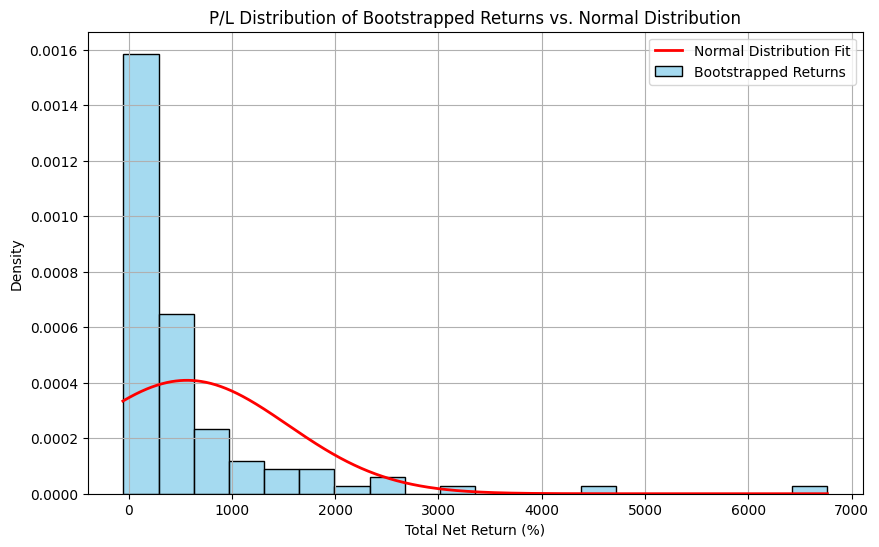

Mean Total Return: 565.09%
t-statistic: 5.79
p-value: 0.0000
The mean total return differs significantly from zero (p < 0.05).


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, ttest_1samp

# Assume df_perf is your DataFrame with the performance metrics from the bootstrap samples.
# Here we extract the Total net return (%) as our P/L metric.
# Convert to decimals (if stored as percentages, e.g., 15% -> 0.15) if necessary.
# In this example, we assume they are stored as percentages, so we'll convert to decimals.

# For clarity, we'll use the Total net return in percent as is:
pl_returns = df_perf['Total net return (%)'].values

# Calculate sample statistics
mean_return = np.mean(pl_returns)
std_return = np.std(pl_returns, ddof=1)
n = len(pl_returns)

# Create a range for the x-axis based on the data
x_min, x_max = pl_returns.min() - 5, pl_returns.max() + 5
x = np.linspace(x_min, x_max, 1000)

# Calculate the normal distribution's probability density function using the sample mean and std
pdf = norm.pdf(x, mean_return, std_return)

# Plot the histogram of the bootstrapped returns
plt.figure(figsize=(10, 6))
sns.histplot(pl_returns, bins=20, kde=False, stat='density', color='skyblue', label='Bootstrapped Returns')

# Overlay the Normal distribution curve
plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution Fit')
plt.xlabel('Total Net Return (%)')
plt.ylabel('Density')
plt.title('P/L Distribution of Bootstrapped Returns vs. Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# Perform a t-test to see if the mean total return differs significantly from zero
# Null hypothesis: The mean return = 0
t_stat, p_value = ttest_1samp(pl_returns, popmean=0)

print(f"Mean Total Return: {mean_return:.2f}%")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The mean total return differs significantly from zero (p < 0.05).")
else:
    print("The mean total return does not differ significantly from zero (p >= 0.05).")
